In [1]:
# %%
import torch
from torch import nn
import numpy as np

from pit.dynamics.dynamic_bicycle import DynamicBicycle
from pit.parameters import NormalParameterGroup, CovariantNormalParameterGroup, PointParameterGroup
from pit.integration import Euler, RK4

import matplotlib.pyplot as plt
import json

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(DEVICE)

# input parameters
map_name = 'SaoPaulo'  # Nuerburgring,  SaoPaulo
lap_number = 2  # 1 - faster, 2 - slower
friction = '1-1'  # '1-1' - mu_x = 1.1, '0-7' - mu_x = 0.7

# visualization
# with open('dataset_%s_%s_lap%s.json' % (friction, map_name, lap_number), 'r') as f:
#     data = json.load(f)

with open('output_data_1.json', 'r') as f:
     data = json.load(f)

cpu


/home/xlab/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# %%
timestep = 0.01
# assert(data['time'][1] - data['time'][0] - timestep < 0.001)
x = torch.tensor(data['x'][200:801])
y = torch.tensor(data['y'][200:801])
yaw = torch.tensor(data['yaw'][200:801])
yaw_rate = torch.tensor(data['yaw_rate'][200:801])
steer_angle = torch.tensor(data['steer_angle'][200:801])
drive_force = torch.tensor(data['drive_force'][200:801])
steer_speed = torch.tensor(data['steer_speed'][200:801])
delta_times = torch.tensor(data['dt'][200:801])

vx = torch.tensor(data['untranslated_vx'][200:801])
vy = torch.tensor(data['untranslated_vy'][200:801])

vy = -1 * vy
vx = -1 * vx
# try:
#     delta_times = torch.tensor(data['dt'])
# except KeyError:
#     delta_times = time[1:] - time[:-1]

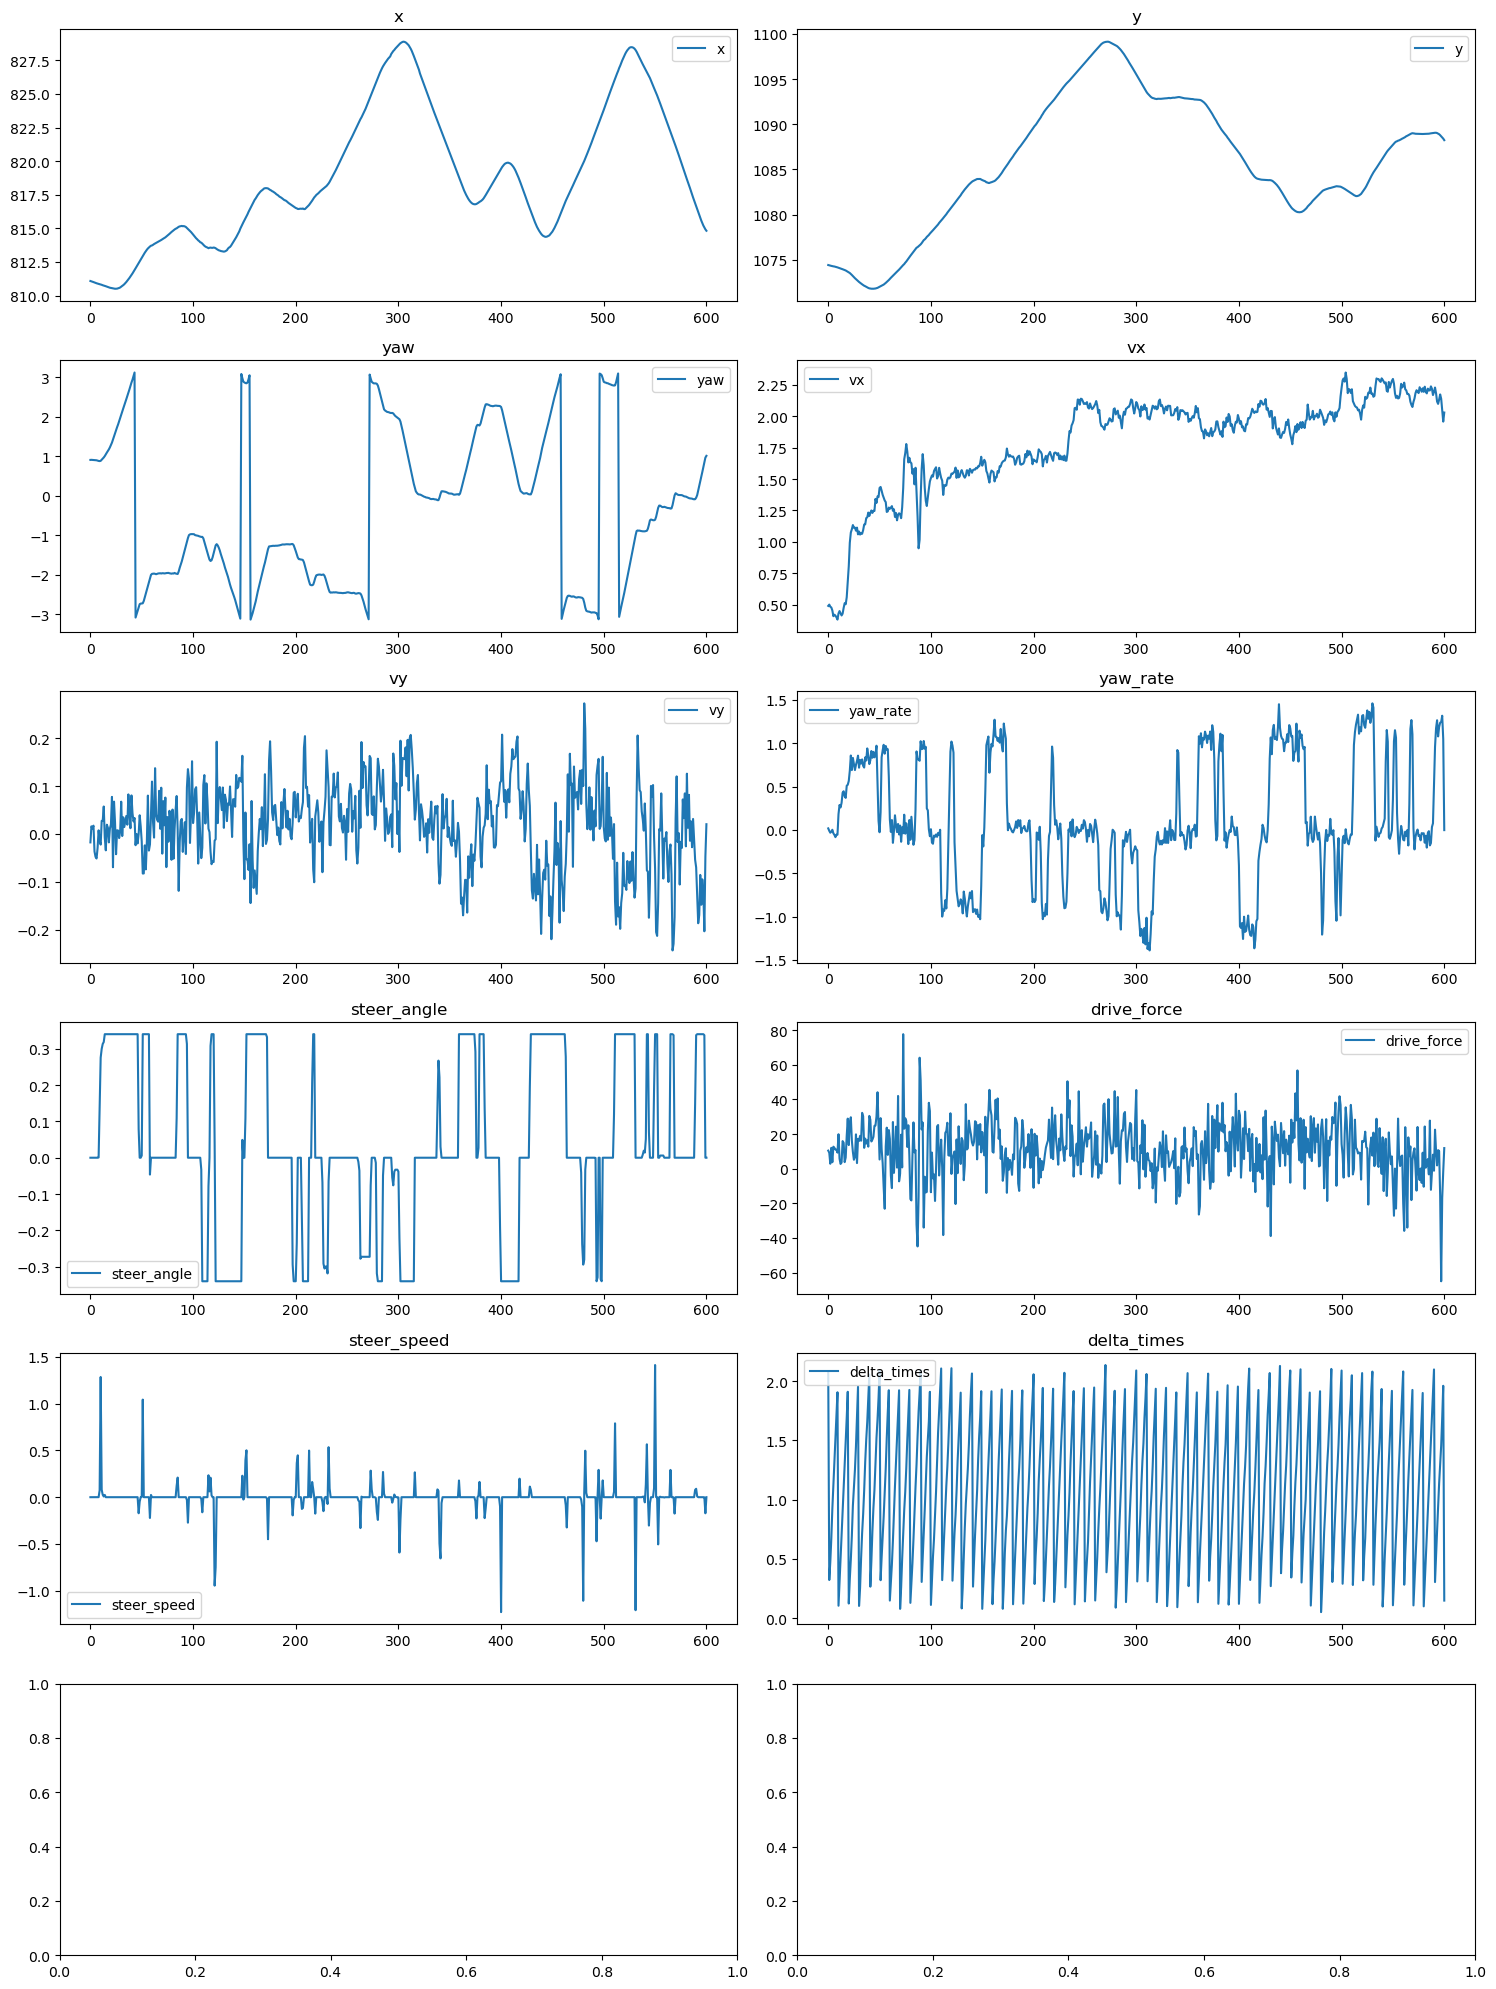

In [3]:
# Plot each tensor
fig, axs = plt.subplots(6, 2, figsize=(15, 20))

# Plot x and y
axs[0, 0].plot(x.numpy(), label='x')
axs[0, 0].set_title('x')
axs[0, 0].legend()

axs[0, 1].plot(y.numpy(), label='y')
axs[0, 1].set_title('y')
axs[0, 1].legend()

# Plot yaw and vx
axs[1, 0].plot(yaw.numpy(), label='yaw')
axs[1, 0].set_title('yaw')
axs[1, 0].legend()

axs[1, 1].plot(vx.numpy(), label='vx')
axs[1, 1].set_title('vx')
axs[1, 1].legend()

# Plot vy and yaw_rate
axs[2, 0].plot(vy.numpy(), label='vy')
axs[2, 0].set_title('vy')
axs[2, 0].legend()

axs[2, 1].plot(yaw_rate.numpy(), label='yaw_rate')
axs[2, 1].set_title('yaw_rate')
axs[2, 1].legend()

# Plot steer_angle and drive_force
axs[3, 0].plot(steer_angle.numpy(), label='steer_angle')
axs[3, 0].set_title('steer_angle')
axs[3, 0].legend()

axs[3, 1].plot(drive_force.numpy(), label='drive_force')
axs[3, 1].set_title('drive_force')
axs[3, 1].legend()

# Plot steer_speed and delta_times
axs[4, 0].plot(steer_speed.numpy(), label='steer_speed')
axs[4, 0].set_title('steer_speed')
axs[4, 0].legend()

axs[4, 1].plot(delta_times.numpy(), label='delta_times')
axs[4, 1].set_title('delta_times')
axs[4, 1].legend()

# axs[5, 0].plot(untranslated_vx.numpy(), label='untranslated_vx')
# axs[5, 0].set_title('untranslated_vx')
# axs[5, 0].legend()

# axs[5, 1].plot(untranslated_vy.numpy(), label='untranslated_vy')
# axs[5, 1].set_title('untranslated_vy')
# axs[5, 1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [4]:
# %%
initial_state = torch.tensor([x[0],y[0],yaw[0],vx[0],vy[0],yaw_rate[0],steer_angle[0]]).to(DEVICE)
control_inputs = torch.vstack([drive_force, steer_speed]).T
control_inputs = control_inputs.contiguous().to(DEVICE)
output_states = torch.vstack([x, y, yaw, vx, vy, yaw_rate, steer_angle]).T
target_states = output_states#[1:]
target_states = target_states.contiguous().to(DEVICE)


print(f"Inputs size: {control_inputs.shape} | States size: {target_states.shape}")

Inputs size: torch.Size([601, 2]) | States size: torch.Size([601, 7])


In [5]:
# %%
STEP_SIZE=10
TICKS_IN_STEP=5
state_dims = initial_state.shape[0]
input_dims = control_inputs.shape[-1]
total_steps = (control_inputs.shape[0]-TICKS_IN_STEP-1)//STEP_SIZE

batched_initial_states = torch.zeros((total_steps, state_dims), device=DEVICE)
batched_control_inputs = torch.zeros((total_steps, TICKS_IN_STEP, input_dims), device=DEVICE)
batched_target_states = torch.zeros((total_steps, TICKS_IN_STEP, state_dims), device=DEVICE)
batched_delta_time = torch.zeros((total_steps, TICKS_IN_STEP), device=DEVICE)

for step in range(total_steps):
    batched_initial_states[step] = output_states[step*STEP_SIZE]
    batched_control_inputs[step] = control_inputs[step*STEP_SIZE:(step*STEP_SIZE)+TICKS_IN_STEP]
    batched_target_states[step] = output_states[(step*  STEP_SIZE)+1:(step*STEP_SIZE)+TICKS_IN_STEP+1]
    batched_delta_time[step] = delta_times[step*STEP_SIZE:(step*STEP_SIZE)+TICKS_IN_STEP]

print(f"Batched Inputs size: {batched_control_inputs.shape} | Batched States size: {batched_target_states.shape}")

Batched Inputs size: torch.Size([59, 5, 2]) | Batched States size: torch.Size([59, 5, 7])


In [6]:
# %%
dataset = torch.utils.data.TensorDataset(batched_initial_states, batched_control_inputs, batched_target_states, batched_delta_time)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)

In [7]:
# %%
params = {
    # axes distances
    'lf': 0.2725,  # distance from spring mass center of gravity to front axle [m]  LENA
    'lr': 0.2585,  # distance from spring mass center of gravity to rear axle [m]  LENB

    # moments of inertia of sprung mass
    # masses
    'Iz': 0.6433215993,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
    'mass': 15.32,  # vehicle mass [kg]  MASS

    # Pacejka tire force parameters
    'Df': 3709.08227,  # [rad/m]  DF
    'Cf': 1.3507,
    'Bf': 16.2216,
    'Dr': 3709.08227,  # [rad/m]  DR
    'Cr': 1.3507,
    'Br': 16.2216,
    'Cm': 0.3777,
    'Cr0': 2.1469,
    'Cr2': 0.0,
}
# params.update({
# 	"lf" : 0.27250000834465027,
# 	"lr" : 0.25850000977516174,
# 	"Iz" : 0.6433215737342834,
# 	"mass" : 15.319999694824219,
# 	"Df" : 3709.082275390625,
# 	"Cf" : 1.3507000207901,
# 	"Bf" : 16.221599578857422,
# 	"Dr" : 3709.082275390625,
# 	"Cr" : 1.3507000207901,
# 	"Br" : 16.221599578857422,
# 	"Cm" : 0.4104667901992798,
# 	"Cr0" : 1.9748075008392334,
# 	"Cr2" : 0.5565943121910095,
# })
dynamics = DynamicBicycle(**params)
param_group = PointParameterGroup(dynamics.parameter_list, params)

# Disable gradients for physical parameters
for param in ['lf', 'lr', 'Iz', 'mass']:
    param_group.disable_gradients(param)

for param in ['Df', 'Cf', 'Bf', 'Dr', 'Cr', 'Br', 'Cm', 'Cr0', 'Cr2']:
    param_group.enable_gradients(param)
    
#dynamics = torch.load("fitted_model.pt")
# <---- FIX PHYSICAL PARAMS     ---->
# dynamics.lf.requires_grad = False
# dynamics.lr.requires_grad = False
# dynamics.mass.requires_grad = False
# dynamics.Iz.requires_grad = False
# dynamics.Df.requires_grad = True
# dynamics.Cf.requires_grad = True
# dynamics.Bf.requires_grad = True
# dynamics.Dr.requires_grad = True
# dynamics.Cr.requires_grad = True
# dynamics.Br.requires_grad = True
# dynamics.Cm.requires_grad = True
# dynamics.Cr0.requires_grad = True
# dynamics.Cr2.requires_grad = True
# <----                         ---->
# euler_integrator = Euler(dynamics, parameters=param_group, timestep=timestep)
# euler_integrator.to(DEVICE)
rk4_integrator = RK4(dynamics=dynamics, parameters=param_group, timestep=timestep)
rk4_integrator.to(DEVICE)

RK4(
  (dynamics): DynamicBicycle()
  (model_params): PointParameterGroup(
    (params): ParameterDict(
        (lf): Parameter containing: [torch.FloatTensor of size ]
        (lr): Parameter containing: [torch.FloatTensor of size ]
        (Iz): Parameter containing: [torch.FloatTensor of size ]
        (mass): Parameter containing: [torch.FloatTensor of size ]
        (Df): Parameter containing: [torch.FloatTensor of size ]
        (Cf): Parameter containing: [torch.FloatTensor of size ]
        (Bf): Parameter containing: [torch.FloatTensor of size ]
        (Dr): Parameter containing: [torch.FloatTensor of size ]
        (Cr): Parameter containing: [torch.FloatTensor of size ]
        (Br): Parameter containing: [torch.FloatTensor of size ]
        (Cm): Parameter containing: [torch.FloatTensor of size ]
        (Cr0): Parameter containing: [torch.FloatTensor of size ]
        (Cr2): Parameter containing: [torch.FloatTensor of size ]
    )
  )
)

In [8]:
with torch.no_grad():
    rk4_output_states = rk4_integrator(initial_state, control_inputs, delta_times)


In [9]:
#print first five euer output states
# initial_state = torch.tensor([x[0],y[0],yaw[0],vx[0],vy[0],yaw_rate[0],steer_angle[0]]).to(DEVICE)
print(rk4_output_states[:10])

tensor([[-1.2600e+06,  5.3515e+06, -2.2006e+02, -8.1639e+08, -7.1986e+06,
         -8.2297e+01,  0.0000e+00],
        [-2.6146e+08,  4.5380e+07, -2.4653e+02, -6.2584e+08, -2.1618e+10,
         -5.9486e+01,  0.0000e+00],
        [-1.0482e+10,  1.2457e+09, -2.7469e+02,  6.0818e+11, -3.9243e+10,
         -2.5912e+01,  0.0000e+00],
        [-6.6249e+10,  3.9743e+11, -2.9214e+02,  1.2932e+12,  1.0576e+13,
          2.2314e+01,  0.0000e+00],
        [-1.0184e+12,  1.0132e+13, -2.7154e+02,  2.1924e+14, -1.6072e+13,
         -4.3334e+01,  0.0000e+00],
        [ 3.3038e+13, -2.2722e+14, -3.2029e+02,  1.0027e+15,  1.0672e+16,
          4.0487e+01,  0.0000e+00],
        [-8.6105e+14, -1.4006e+16, -2.6657e+02,  5.7429e+17, -4.3194e+16,
         -5.3781e+01,  0.0000e+00],
        [-8.1241e+17, -4.6933e+17, -3.4865e+02,  4.1199e+18,  4.7098e+19,
          6.0734e+01,  0.0000e+00],
        [-2.6838e+18,  7.9560e+19, -2.4466e+02,  4.9021e+21, -3.8136e+20,
         -6.0904e+01,  6.1136e-04],
        [ 

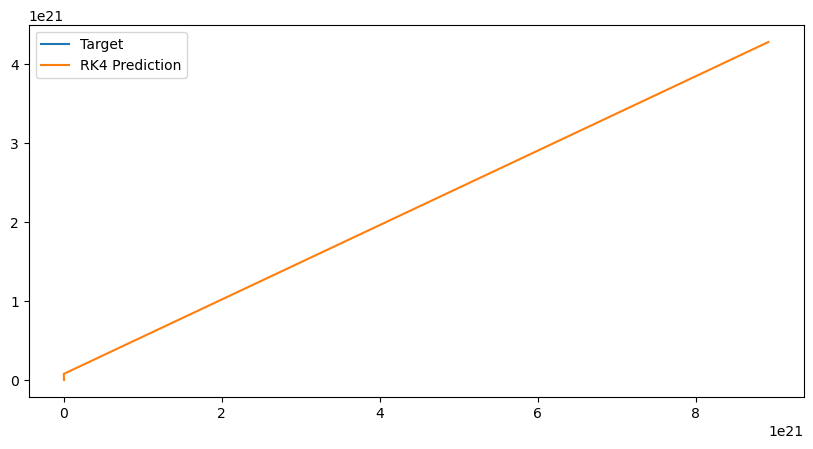

In [10]:
# %%
fig, ax = plt.subplots(1, 1, figsize=(10,10))
LEN=20000
ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
# ax.plot(euler_output_states[:LEN, 0].detach().cpu().numpy(), euler_output_states[:LEN, 1].detach().cpu().numpy(), label="Euler Prediction")
ax.plot(rk4_output_states[:LEN, 0].detach().cpu().numpy(), rk4_output_states[:LEN, 1].detach().cpu().numpy(), label="RK4 Prediction")
ax.set_aspect(1.0)
ax.legend()

In [11]:
# %%
from tqdm.auto import tqdm
EPOCHS = 100
integrator = rk4_integrator
optimizer = torch.optim.SGD(integrator.parameters(), lr=1, momentum=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.9)

with torch.no_grad():
        output_states = integrator(initial_state, control_inputs)
        val_loss = torch.nn.functional.l1_loss(output_states, target_states)
print(f"Initialized | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

losses = list()
lrs = list()

for i in tqdm(range(EPOCHS)):
    for initial, inputs, targets, dts in dataloader:
        integrator.train()
        optimizer.zero_grad()
        output_states = integrator(initial, inputs, dts)
        loss = torch.nn.functional.l1_loss(output_states, targets)
        loss.backward()
        optimizer.step()
    #for name, param in integrator.named_parameters():
    #    if param.requires_grad:
    #        print(name, param.data, param.grad)
    if i%20 == 0 and False:
        with torch.no_grad():
            output_states = integrator(initial_state, control_inputs, dts)
            val_loss = torch.nn.functional.l1_loss(output_states, target_states)
        fig, ax = plt.subplots(1, 1, figsize=(10,10))
        LEN=20000
        ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
        ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
        ax.set_aspect(1.0)
        ax.legend()
        plt.show()
        print(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    with torch.no_grad():
        integrator.eval()
        output_states = integrator(batched_initial_states,batched_control_inputs, batched_delta_time)
        val_loss = torch.nn.functional.l1_loss(output_states, batched_target_states)
        losses.append(val_loss.item())
    print(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step(val_loss)


/home/xlab/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initialized | Validation Loss: 9.48253345489502 | LR: 1


  3%|▎         | 3/100 [00:00<00:04, 22.26it/s]

Epoch: 0 | Training Loss: nan | Validation Loss: nan | LR: 1
Epoch: 1 | Training Loss: nan | Validation Loss: nan | LR: 1
Epoch: 2 | Training Loss: nan | Validation Loss: nan | LR: 1
Epoch: 3 | Training Loss: nan | Validation Loss: nan | LR: 1
Epoch: 4 | Training Loss: nan | Validation Loss: nan | LR: 1


  9%|▉         | 9/100 [00:00<00:03, 23.24it/s]

Epoch: 5 | Training Loss: nan | Validation Loss: nan | LR: 1
Epoch: 6 | Training Loss: nan | Validation Loss: nan | LR: 1
Epoch: 7 | Training Loss: nan | Validation Loss: nan | LR: 1
Epoch: 8 | Training Loss: nan | Validation Loss: nan | LR: 1
Epoch: 9 | Training Loss: nan | Validation Loss: nan | LR: 1


 12%|█▏        | 12/100 [00:00<00:03, 22.69it/s]

Epoch: 10 | Training Loss: nan | Validation Loss: nan | LR: 1
Epoch: 11 | Training Loss: nan | Validation Loss: nan | LR: 0.9
Epoch: 12 | Training Loss: nan | Validation Loss: nan | LR: 0.9
Epoch: 13 | Training Loss: nan | Validation Loss: nan | LR: 0.9


 15%|█▌        | 15/100 [00:00<00:03, 22.30it/s]

Epoch: 14 | Training Loss: nan | Validation Loss: nan | LR: 0.9


 18%|█▊        | 18/100 [00:00<00:03, 22.19it/s]

Epoch: 15 | Training Loss: nan | Validation Loss: nan | LR: 0.9
Epoch: 16 | Training Loss: nan | Validation Loss: nan | LR: 0.9
Epoch: 17 | Training Loss: nan | Validation Loss: nan | LR: 0.9
Epoch: 18 | Training Loss: nan | Validation Loss: nan | LR: 0.9
Epoch: 19 | Training Loss: nan | Validation Loss: nan | LR: 0.9


 24%|██▍       | 24/100 [00:01<00:03, 22.03it/s]

Epoch: 20 | Training Loss: nan | Validation Loss: nan | LR: 0.9
Epoch: 21 | Training Loss: nan | Validation Loss: nan | LR: 0.9
Epoch: 22 | Training Loss: nan | Validation Loss: nan | LR: 0.81
Epoch: 23 | Training Loss: nan | Validation Loss: nan | LR: 0.81
Epoch: 24 | Training Loss: nan | Validation Loss: nan | LR: 0.81


 27%|██▋       | 27/100 [00:01<00:03, 21.89it/s]

Epoch: 25 | Training Loss: nan | Validation Loss: nan | LR: 0.81
Epoch: 26 | Training Loss: nan | Validation Loss: nan | LR: 0.81
Epoch: 27 | Training Loss: nan | Validation Loss: nan | LR: 0.81
Epoch: 28 | Training Loss: nan | Validation Loss: nan | LR: 0.81


 30%|███       | 30/100 [00:01<00:03, 21.95it/s]

Epoch: 29 | Training Loss: nan | Validation Loss: nan | LR: 0.81


 33%|███▎      | 33/100 [00:01<00:03, 21.91it/s]

Epoch: 30 | Training Loss: nan | Validation Loss: nan | LR: 0.81
Epoch: 31 | Training Loss: nan | Validation Loss: nan | LR: 0.81
Epoch: 32 | Training Loss: nan | Validation Loss: nan | LR: 0.81
Epoch: 33 | Training Loss: nan | Validation Loss: nan | LR: 0.7290000000000001
Epoch: 34 | Training Loss: nan | Validation Loss: nan | LR: 0.7290000000000001


 39%|███▉      | 39/100 [00:01<00:02, 22.01it/s]

Epoch: 35 | Training Loss: nan | Validation Loss: nan | LR: 0.7290000000000001
Epoch: 36 | Training Loss: nan | Validation Loss: nan | LR: 0.7290000000000001
Epoch: 37 | Training Loss: nan | Validation Loss: nan | LR: 0.7290000000000001
Epoch: 38 | Training Loss: nan | Validation Loss: nan | LR: 0.7290000000000001
Epoch: 39 | Training Loss: nan | Validation Loss: nan | LR: 0.7290000000000001


 42%|████▏     | 42/100 [00:01<00:02, 21.97it/s]

Epoch: 40 | Training Loss: nan | Validation Loss: nan | LR: 0.7290000000000001
Epoch: 41 | Training Loss: nan | Validation Loss: nan | LR: 0.7290000000000001
Epoch: 42 | Training Loss: nan | Validation Loss: nan | LR: 0.7290000000000001
Epoch: 43 | Training Loss: nan | Validation Loss: nan | LR: 0.7290000000000001


 45%|████▌     | 45/100 [00:02<00:02, 21.65it/s]

Epoch: 44 | Training Loss: nan | Validation Loss: nan | LR: 0.6561000000000001


 48%|████▊     | 48/100 [00:02<00:02, 22.02it/s]

Epoch: 45 | Training Loss: nan | Validation Loss: nan | LR: 0.6561000000000001
Epoch: 46 | Training Loss: nan | Validation Loss: nan | LR: 0.6561000000000001
Epoch: 47 | Training Loss: nan | Validation Loss: nan | LR: 0.6561000000000001
Epoch: 48 | Training Loss: nan | Validation Loss: nan | LR: 0.6561000000000001
Epoch: 49 | Training Loss: nan | Validation Loss: nan | LR: 0.6561000000000001


 54%|█████▍    | 54/100 [00:02<00:02, 22.23it/s]

Epoch: 50 | Training Loss: nan | Validation Loss: nan | LR: 0.6561000000000001
Epoch: 51 | Training Loss: nan | Validation Loss: nan | LR: 0.6561000000000001
Epoch: 52 | Training Loss: nan | Validation Loss: nan | LR: 0.6561000000000001
Epoch: 53 | Training Loss: nan | Validation Loss: nan | LR: 0.6561000000000001
Epoch: 54 | Training Loss: nan | Validation Loss: nan | LR: 0.6561000000000001


 57%|█████▋    | 57/100 [00:02<00:01, 22.24it/s]

Epoch: 55 | Training Loss: nan | Validation Loss: nan | LR: 0.5904900000000002
Epoch: 56 | Training Loss: nan | Validation Loss: nan | LR: 0.5904900000000002
Epoch: 57 | Training Loss: nan | Validation Loss: nan | LR: 0.5904900000000002
Epoch: 58 | Training Loss: nan | Validation Loss: nan | LR: 0.5904900000000002


 60%|██████    | 60/100 [00:02<00:01, 22.38it/s]

Epoch: 59 | Training Loss: nan | Validation Loss: nan | LR: 0.5904900000000002


 63%|██████▎   | 63/100 [00:02<00:01, 22.41it/s]

Epoch: 60 | Training Loss: nan | Validation Loss: nan | LR: 0.5904900000000002
Epoch: 61 | Training Loss: nan | Validation Loss: nan | LR: 0.5904900000000002
Epoch: 62 | Training Loss: nan | Validation Loss: nan | LR: 0.5904900000000002
Epoch: 63 | Training Loss: nan | Validation Loss: nan | LR: 0.5904900000000002
Epoch: 64 | Training Loss: nan | Validation Loss: nan | LR: 0.5904900000000002


 69%|██████▉   | 69/100 [00:03<00:01, 22.62it/s]

Epoch: 65 | Training Loss: nan | Validation Loss: nan | LR: 0.5904900000000002
Epoch: 66 | Training Loss: nan | Validation Loss: nan | LR: 0.5314410000000002
Epoch: 67 | Training Loss: nan | Validation Loss: nan | LR: 0.5314410000000002
Epoch: 68 | Training Loss: nan | Validation Loss: nan | LR: 0.5314410000000002
Epoch: 69 | Training Loss: nan | Validation Loss: nan | LR: 0.5314410000000002


 72%|███████▏  | 72/100 [00:03<00:01, 22.60it/s]

Epoch: 70 | Training Loss: nan | Validation Loss: nan | LR: 0.5314410000000002
Epoch: 71 | Training Loss: nan | Validation Loss: nan | LR: 0.5314410000000002
Epoch: 72 | Training Loss: nan | Validation Loss: nan | LR: 0.5314410000000002
Epoch: 73 | Training Loss: nan | Validation Loss: nan | LR: 0.5314410000000002


 75%|███████▌  | 75/100 [00:03<00:01, 22.70it/s]

Epoch: 74 | Training Loss: nan | Validation Loss: nan | LR: 0.5314410000000002


 78%|███████▊  | 78/100 [00:03<00:00, 22.76it/s]

Epoch: 75 | Training Loss: nan | Validation Loss: nan | LR: 0.5314410000000002
Epoch: 76 | Training Loss: nan | Validation Loss: nan | LR: 0.5314410000000002
Epoch: 77 | Training Loss: nan | Validation Loss: nan | LR: 0.47829690000000014
Epoch: 78 | Training Loss: nan | Validation Loss: nan | LR: 0.47829690000000014
Epoch: 79 | Training Loss: nan | Validation Loss: nan | LR: 0.47829690000000014


 84%|████████▍ | 84/100 [00:03<00:00, 22.80it/s]

Epoch: 80 | Training Loss: nan | Validation Loss: nan | LR: 0.47829690000000014
Epoch: 81 | Training Loss: nan | Validation Loss: nan | LR: 0.47829690000000014
Epoch: 82 | Training Loss: nan | Validation Loss: nan | LR: 0.47829690000000014
Epoch: 83 | Training Loss: nan | Validation Loss: nan | LR: 0.47829690000000014
Epoch: 84 | Training Loss: nan | Validation Loss: nan | LR: 0.47829690000000014


 87%|████████▋ | 87/100 [00:03<00:00, 22.77it/s]

Epoch: 85 | Training Loss: nan | Validation Loss: nan | LR: 0.47829690000000014
Epoch: 86 | Training Loss: nan | Validation Loss: nan | LR: 0.47829690000000014
Epoch: 87 | Training Loss: nan | Validation Loss: nan | LR: 0.47829690000000014
Epoch: 88 | Training Loss: nan | Validation Loss: nan | LR: 0.43046721000000016


 90%|█████████ | 90/100 [00:04<00:00, 22.76it/s]

Epoch: 89 | Training Loss: nan | Validation Loss: nan | LR: 0.43046721000000016


 93%|█████████▎| 93/100 [00:04<00:00, 22.47it/s]

Epoch: 90 | Training Loss: nan | Validation Loss: nan | LR: 0.43046721000000016
Epoch: 91 | Training Loss: nan | Validation Loss: nan | LR: 0.43046721000000016
Epoch: 92 | Training Loss: nan | Validation Loss: nan | LR: 0.43046721000000016
Epoch: 93 | Training Loss: nan | Validation Loss: nan | LR: 0.43046721000000016
Epoch: 94 | Training Loss: nan | Validation Loss: nan | LR: 0.43046721000000016


 99%|█████████▉| 99/100 [00:04<00:00, 21.54it/s]

Epoch: 95 | Training Loss: nan | Validation Loss: nan | LR: 0.43046721000000016
Epoch: 96 | Training Loss: nan | Validation Loss: nan | LR: 0.43046721000000016
Epoch: 97 | Training Loss: nan | Validation Loss: nan | LR: 0.43046721000000016
Epoch: 98 | Training Loss: nan | Validation Loss: nan | LR: 0.43046721000000016


100%|██████████| 100/100 [00:04<00:00, 22.23it/s]

Epoch: 99 | Training Loss: nan | Validation Loss: nan | LR: 0.38742048900000015


In [12]:
initial.shape, inputs.shape, targets.shape, dts.shape

(torch.Size([59, 7]),
 torch.Size([59, 5, 2]),
 torch.Size([59, 5, 7]),
 torch.Size([59, 5]))

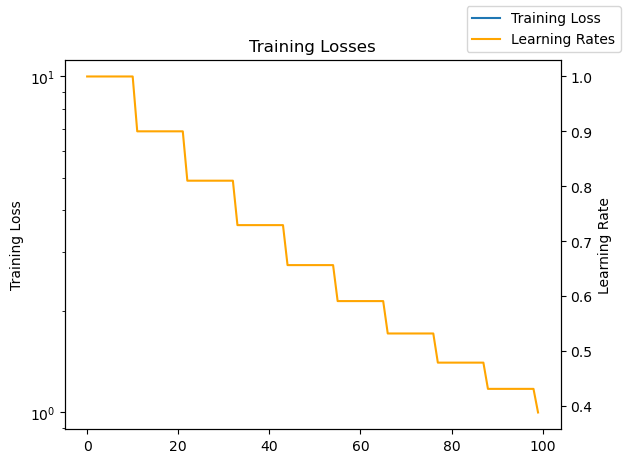

In [13]:
fig, ax = plt.subplots()
ax.plot(losses, label='Training Loss')
ax.set_ylabel("Training Loss")
ax.set_yscale('log')
secax = ax.twinx()
secax.set_ylabel("Learning Rate")
secax.plot(lrs, label="Learning Rates", color='orange')
#secax.set_yscale('log')
ax.set_title("Training Losses")
fig.legend()
plt.show()

In [14]:
# %%
with torch.no_grad():
    integrator.eval()
    output_states = integrator(initial_state, control_inputs, delta_times)
    val_loss = torch.nn.functional.l1_loss(output_states, target_states)

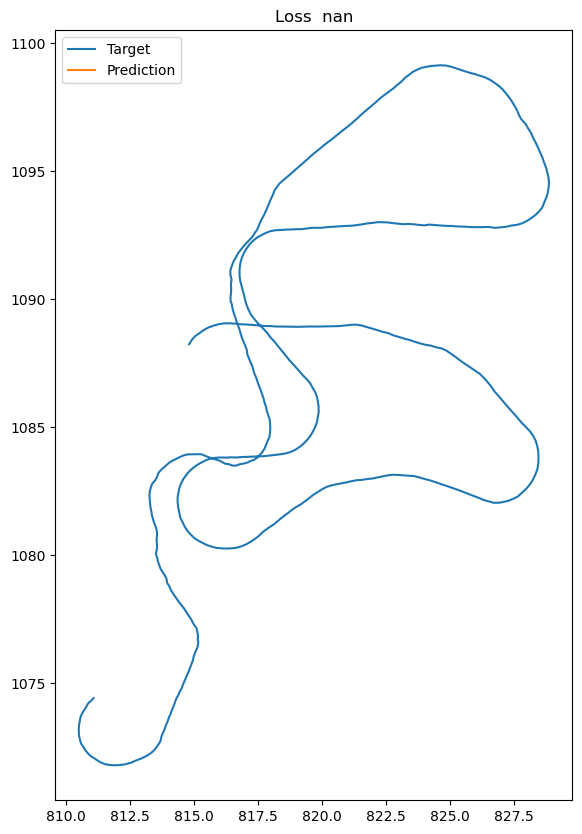

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
LEN=20000
ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
ax.set_aspect(1.0)
ax.legend()
ax.set_title("Loss {:4f}".format(val_loss.item()))
plt.show()

In [16]:
print("{")
for key in param_group.state_dict().keys():
    print(f"\t\"{key}\" : {param_group .state_dict()[key]},")
print("}")

{
	"params.lf" : 0.27250000834465027,
	"params.lr" : 0.25850000977516174,
	"params.Iz" : 0.6433215737342834,
	"params.mass" : 15.319999694824219,
	"params.Df" : nan,
	"params.Cf" : nan,
	"params.Bf" : nan,
	"params.Dr" : nan,
	"params.Cr" : nan,
	"params.Br" : nan,
	"params.Cm" : nan,
	"params.Cr0" : nan,
	"params.Cr2" : nan,
}
